In [1]:
import scanpy as sc
import os
import pandas as pd
import matplotlib as mpl
import sys
import numpy as np
import matplotlib.pyplot as plt
import diffxpy.api as de
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
import shoji
%reload_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.minor.pad'] = 2
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.minor.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-06-15 02:10:54.923357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 02:11:03.847774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/wsfish/glioblastoma/FISHspace/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stabl

In [2]:
db = shoji.connect()

In [3]:
#SL040 = db.builds.jesper.GBM_multi.SL040
SL040 = db.builds.jesper.GBM_all.SL040

In [4]:
dic = {s:l for s,l in zip(SL040.Sample[:], SL040.Location[:])}

In [5]:
location_palette = {
    'core':'#c44d56',
    'high':'#f1d693',
    'low':'#19b5fe',
    'periphery':'#66cc99',   
}

location_dic = {
    'Ant high fluo':'high', 
    'Ant low fluo':'low', 
    'Ant no fluo':'periphery', 
    'Cortex':'periphery',
    'Inf high fluo': 'high', 
    'Inf no fluo':'periphery', 
    'Necrotic core':'core', 
    'Pos high fluo':'high', 
    'Pos no fluo':'periphery', 
    'Sup high fluo':'high', 
    'Sup low fluo':'low', 
    'Sup no fluo':'periphery',
}


In [6]:
neftelscore = SL040.NeftelScore[:]
MESscore = neftelscore[:,1]

In [7]:
neftelscore.shape

(135482, 4)

In [8]:
emb = SL040.Embedding[:]
genes = SL040.Gene[:]
exp = SL040.Expression[:]

In [9]:
def plot_gene(
    gene,
    gene_order,
    exp,
    emb,
    s=1,
    figsize=(6,6),
    ):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=1)
    ax.set_xticks([])
    ax.set_yticks([])

    expression_gene = exp[:,gene_order == gene]
    zeros = expression_gene
    xy = emb
    bgval = 0

    cells = expression_gene > bgval
    cells = cells[:,0]
    color = expression_gene[cells]
    order = color.argsort(axis=0)

    xy_ = xy[cells]
    xy_ = xy_[order][:,0,:]
    color = color[order][:,0,0]
    color = np.log(color + 1)

    ax.scatter(xy[:, 0], xy[:, 1], c="lightgrey", s=s/10, alpha=.5, rasterized=True)
    ax.scatter(xy_[:,0], xy_[:,1], c=color, s=s, cmap='magma', alpha=1, rasterized=True)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_region(
    loc,
    emb,
    s=1,
    figsize=(6,6),
    ):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=1)
    ax.set_xticks([])
    ax.set_yticks([])

    xy = emb
    color = [location_palette[location_dic[l]] for l in loc]
    ax.scatter(xy[:,0], xy[:,1], c=color, s=s, alpha=1, rasterized=True)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    

In [10]:
adata = SL040.anndata()

/datb/sl/alejandro/shoji/shoji/view.py:216: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(X=X_data, obs=pd.DataFrame(obs_data).set_index(obs_key), var=pd.DataFrame(var_data).set_index(var_key), obsm=obsm_data, varm=varm_data, layers=layers_data)


In [11]:
adata.obs['ManualAnnotationSL040'].cat.categories

Index(['Astrocytes', 'B-cells', 'Endothelial', 'Fibroblasts', 'MgTAM',
       'Microglia', 'MoTAM', 'Monocytes', 'NK, T-cells', 'OPCs',
       'Oligodendrocytes', 'Pericytes', 'Tumor', 'VSMC'],
      dtype='object')

In [14]:
'''annotation_alejandro = {
    'Astrocytes (protplasmic)':'Astrocytes', 
    'B-cells, Plasma (more right part)':'B/Plasma Cells',
       
    'Endothelial':'Endo.', 
    'Immune':'Macrophages' , 
    'Immune?': 'Macrophages', 
    'MAC':'Macrophages', 
    'MAC + bottom right DC':'Macrophages/DC',
       
    'MAC + monocyte (+ small dot mast cells bottom right)':'Monocytes',
    'Monocyte':'Monocytes', 
    
    'MAC(microglia?)':'Macrophages',
    
    'Mast-cells': 'Mast cells',
       
    'Microglia, MAC, top separate cluster DC?': 'Microglia', 
    
    'Microglia, top part DC?':'Microglia',
       
    'Microglia?': 'Microglia', 
    'Neurons':'Neuron', 
    'Oligo':'Oligo.', 
    'Oligo, Small separare cluster left are doublets T, NK and oligo':'Oligo.',
       
    'Pericytes, VSMCs (more right part), fibroblasts top part.':'Pericytes',
       
    'T-cell, NK-cell (vertical middle stripe)':'T/NK Cells', 
    'Tumor':'Tumour'
}'''


#adata.obs['annotation'] = pd.Categorical([annotation_alejandro[a] for a in adata.obs['ManualAnnotationSL040'].values])
adata.obs['annotation'] = adata.obs['ManualAnnotationSL040']
adata.obs['location_fluo'] = pd.Categorical([location_dic[l] for l in adata.obs['Location']])


In [36]:
#adata.write_h5ad('SL040.h5ad')

In [15]:
adata.obsm['X_umap'] = adata.obsm['Embedding']

... storing 'End' as categorical
... storing 'Gene' as categorical
... storing 'Start' as categorical
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanp

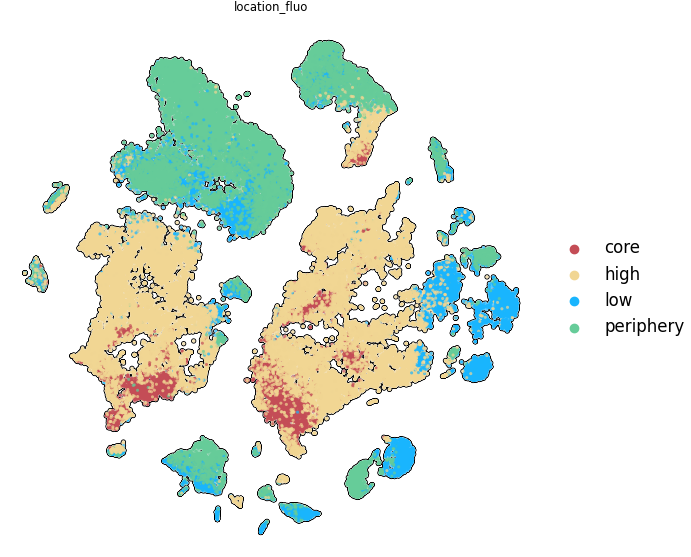

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata, 
    color='location_fluo',
    add_outline=True,
    size=20,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

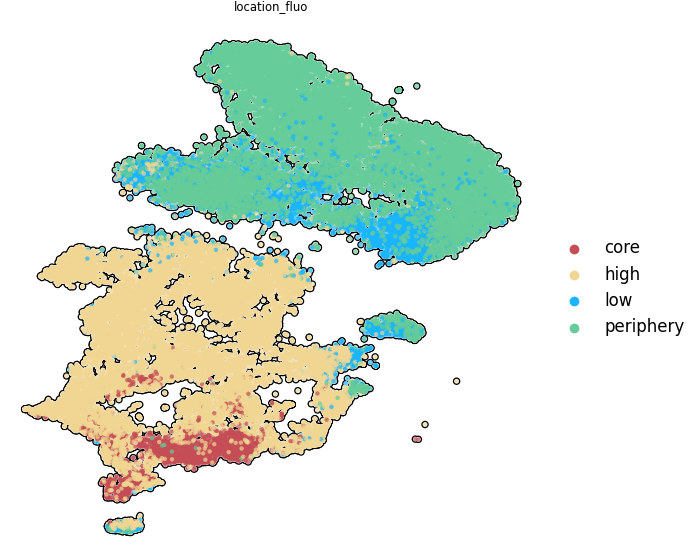

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs.annotation.isin(['MgTAM','Microglia', 'MoTAM', 'Monocytes'])], 
    color='location_fluo',
    add_outline=True,
    size=40,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP_TAMs.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

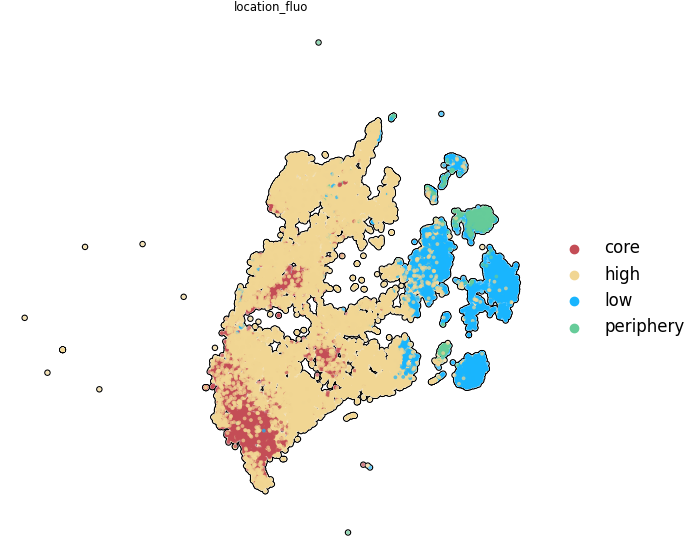

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs.annotation.isin(['Tumor'])], 
    color='location_fluo',
    add_outline=True,
    size=30,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP_Tumour.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

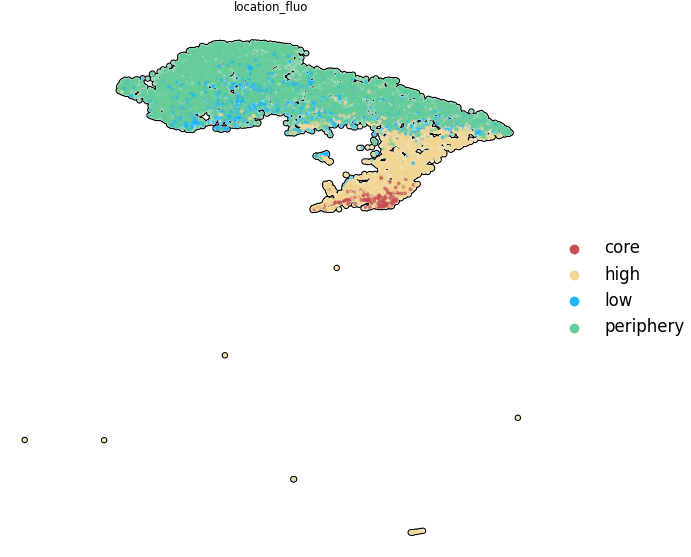

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs.annotation.isin(['Oligodendrocytes'])], 
    color='location_fluo',
    add_outline=True,
    size=30,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP_Oligodendrocytes.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

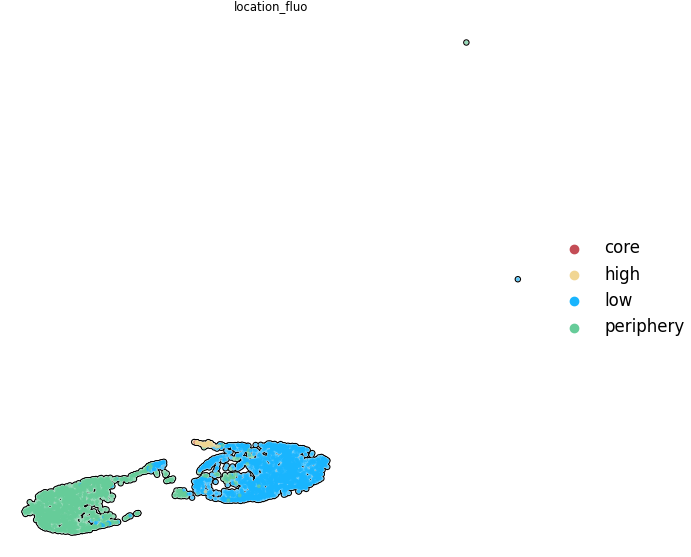

In [37]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs.annotation.isin(['Astrocytes'])], 
    color='location_fluo',
    add_outline=True,
    size=30,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP_Astrocytes.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

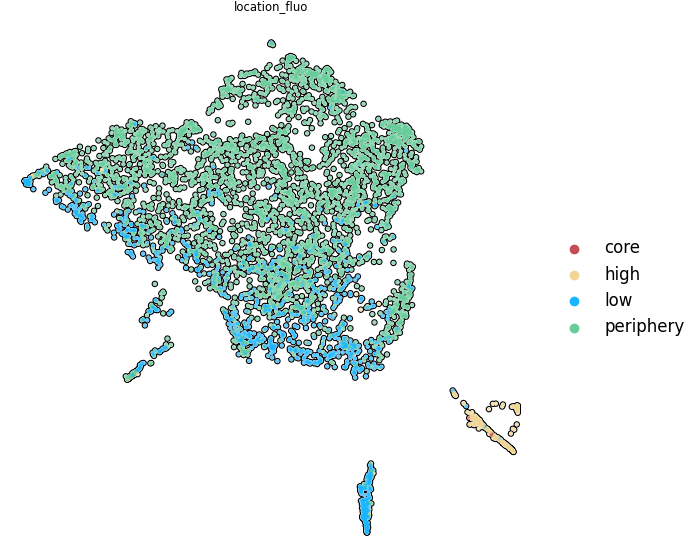

In [38]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs.annotation.isin(['Endothelial'])], 
    color='location_fluo',
    add_outline=True,
    size=30,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,
    palette = location_palette,
    ax=ax,
    show=False,
    
)
plt.savefig('figures/LocationUMAP_Endothelial.png',format='png', dpi=300,transparent=True)
plt.show()

In [28]:
annotation_palette = {
    'Astrocytes': '#038aff',#'#3fc380', 
     'Oligodendrocytes':'#392e4a', 
    
    'B-cells': '#f4ede4', 
    'Endothelial':'#fef160',
    'Fibroblasts':'#f4ede4',
    'NK, T-cells':'#f4ede4',
    'OPCs':'#f4ede4',
    'Pericytes':'#f4ede4',
    'VSMC':'#f4ede4',
    
    'MgTAM':'#5a228b',#'#d2d7d3',
    'MoTAM':'#5a228b',#'#d
    'Microglia':'#5a228b',   
    'Monocytes':'#d5b8ff',
    'Neuron':'#fabe58', 

    'Tumor':'#e76d89',
}

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Paramet

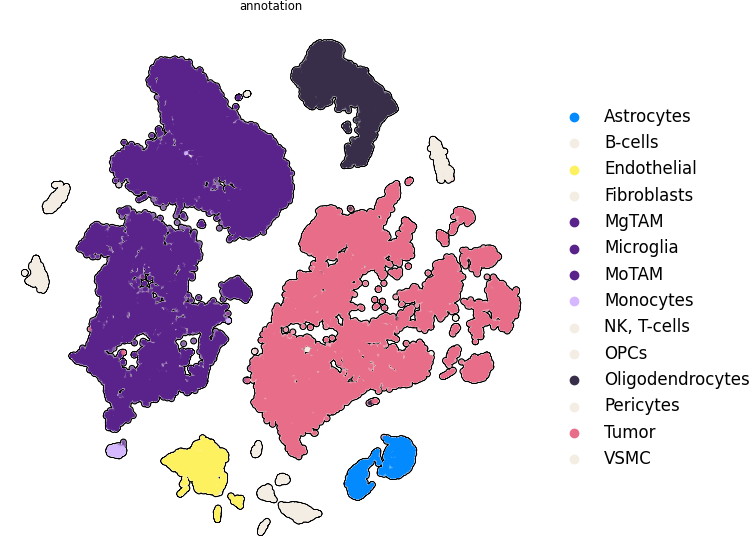

In [29]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata, 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

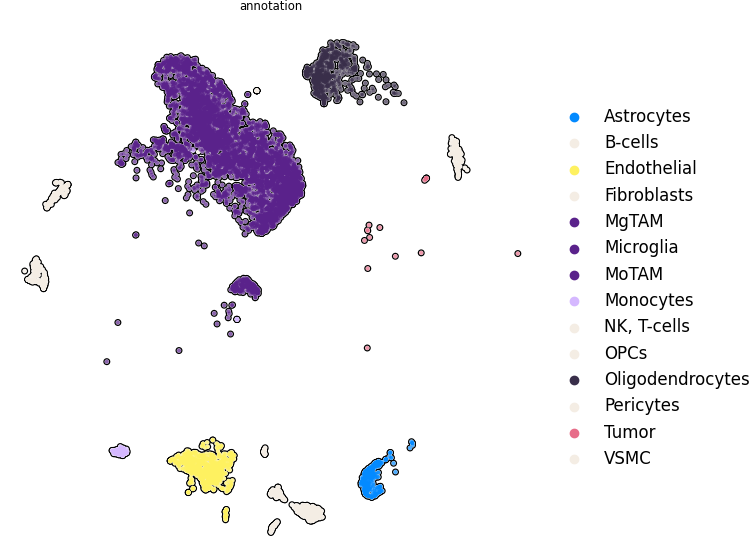

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040F'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040F.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

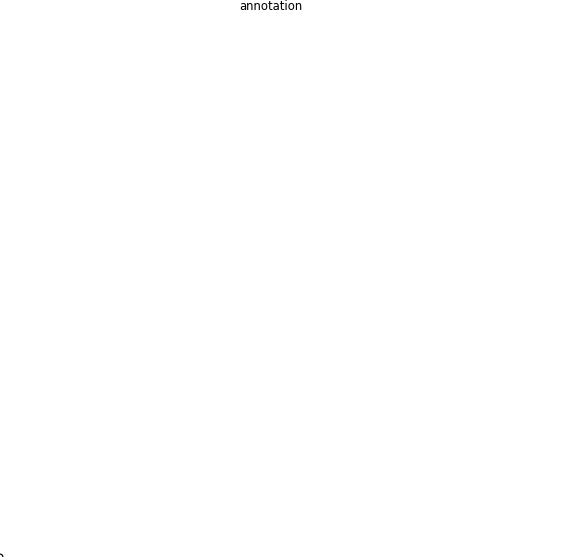

In [31]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

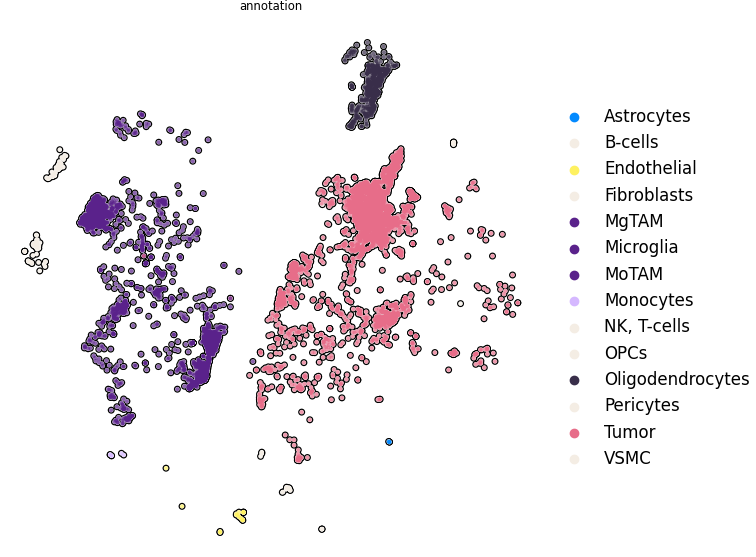

In [39]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040B'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040B.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

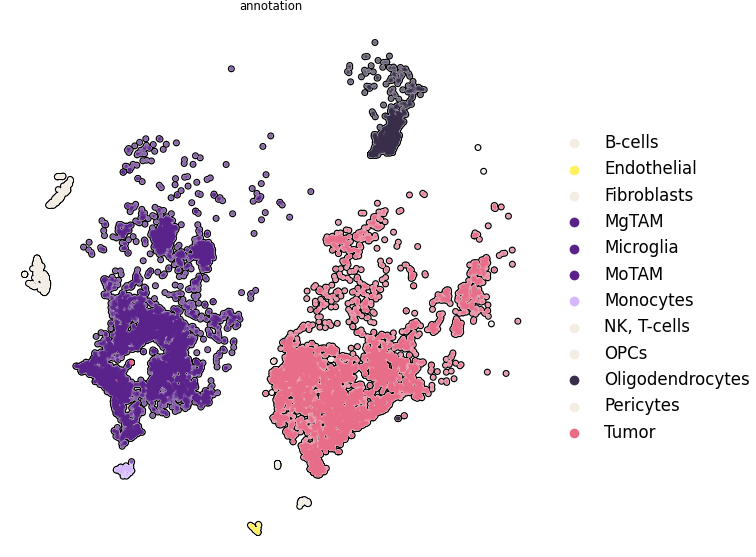

In [32]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040E'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040E.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

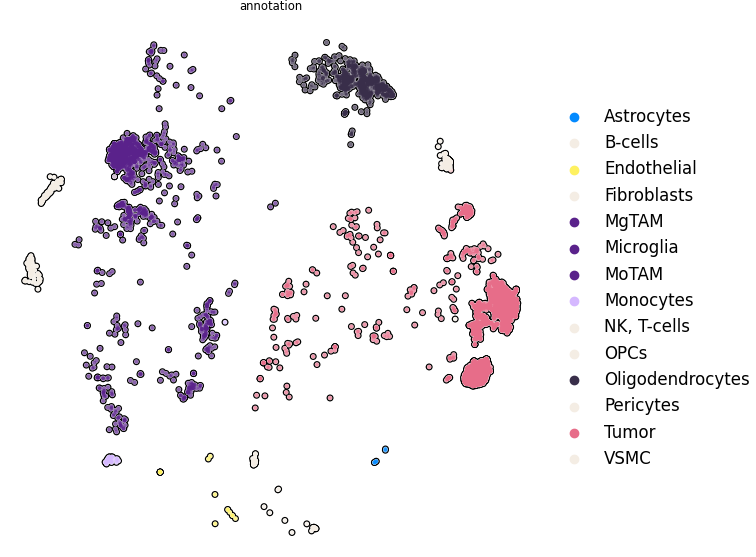

In [33]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040C'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040C.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

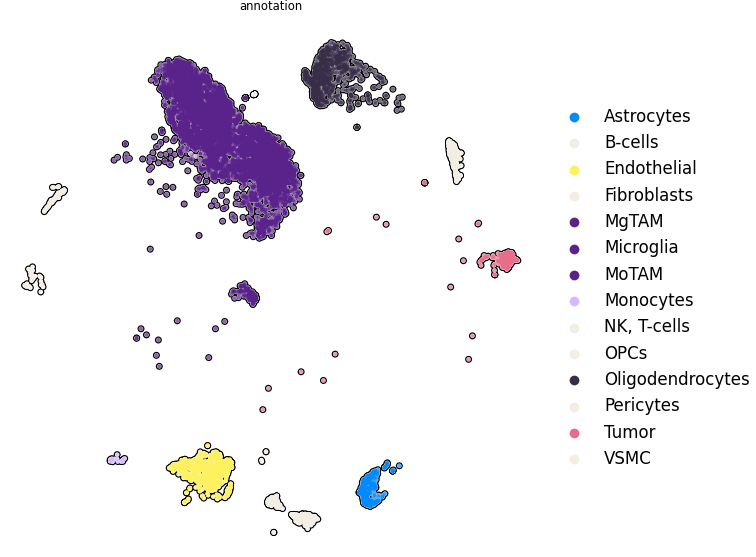

In [34]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040D'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040D.png',format='png', dpi=300,transparent=True)
plt.show()

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provid

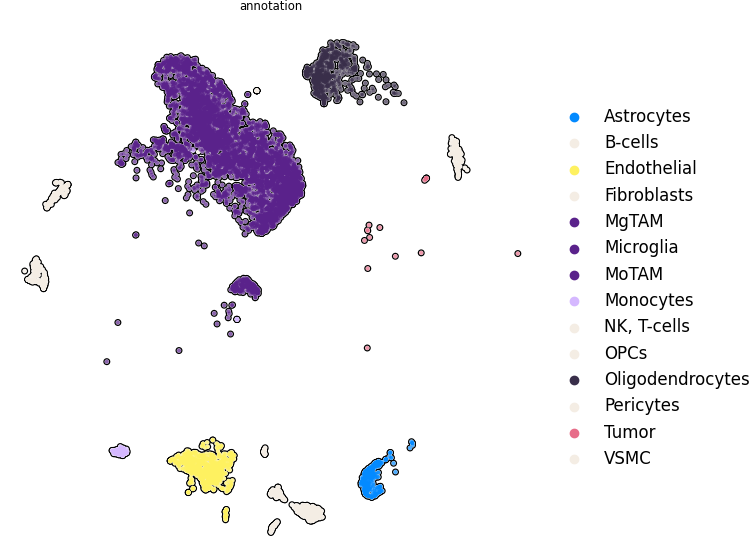

In [35]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
    adata[adata.obs['Sample'] == 'SL040F'], 
    color='annotation',
    add_outline=True,
    size=35,
    #legend_loc="on data",
    legend_fontsize=12,
    legend_fontoutline=2,
    frameon=False,  
    palette=annotation_palette,
    ax=ax,
    show=False,
    #save='figures/AnnotationUMAP.pdf',
)


plt.savefig('figures/AnnotationUMAP_SL040F.png',format='png', dpi=300,transparent=True)
plt.show()